# Adding Phase to AddBiomechanics datasets

Step 1: GRF thresholding (20 Nm)
Step 2: Transition identification by taking diff
Step 3: Determine steady state tasks by looking at stride timing
Step 4: Lienarly interpolate phase for all steady state tasks
Step 5: Create another dataset with phase being the main axis (phase divided 
        into 150 points)

In [5]:
# Import stuff, load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load data
df = pd.read_parquet('/datasets/AddBiomechanics/processed_data/Moore2015_time.parquet')
df.columns

Index(['subject', 'task', 'frame_number', 'time_step', 'contact_r',
       'contact_l', 'grf_x_r', 'grf_y_r', 'grf_z_r', 'grf_x_l', 'grf_y_l',
       'grf_z_l', 'cop_x_r', 'cop_y_r', 'cop_z_r', 'cop_x_l', 'cop_y_l',
       'cop_z_l', 'pelvis_angle_s', 'pelvis_angle_f', 'pelvis_angle_t',
       'hip_angle_s_r', 'hip_angle_f_r', 'hip_angle_t_r', 'knee_angle_s_r',
       'ankle_angle_s_r', 'ankle_angle_t_r', 'hip_angle_s_l', 'hip_angle_f_l',
       'hip_angle_t_l', 'knee_angle_s_l', 'ankle_angle_s_l', 'ankle_angle_t_l',
       'dorsi_angle_r', 'dorsi_angle_l', 'shank_angle_r', 'shank_angle_l',
       'thigh_angle_r', 'thigh_angle_l', 'shank_vel_r', 'shank_vel_l',
       'thigh_vel_r', 'thigh_vel_l', 'ankle_vel_r', 'ankle_vel_l',
       'pelvis_vel_s', 'pelvis_vel_f', 'pelvis_vel_t', 'hip_vel_s_r',
       'hip_vel_f_r', 'hip_vel_t_r', 'knee_vel_s_r', 'ankle_vel_s_r',
       'ankle_vel_t_r', 'hip_vel_s_l', 'hip_vel_f_l', 'hip_vel_t_l',
       'knee_vel_s_l', 'ankle_vel_s_l', 'ankle_vel_t_l'

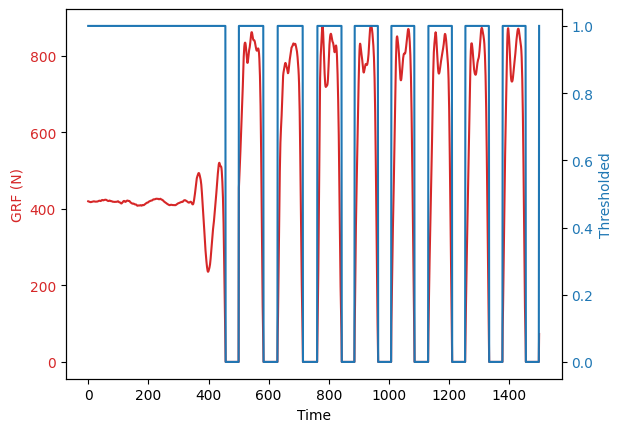

In [7]:
# Step 1: GRF thresholding for the z axis
grf_r = df['grf_y_r'].values # Bug, should be z axis but it's currently the y axis
grf_threshold = 20 # N
grf_thresh = grf_r > grf_threshold

# Plot both the raw and thresholded data in the same plot with 
# two different y axes
fig, ax1 = plt.subplots()

# Plot the first 150 points
start = 1500
end = start + 1500
grf_r_plot = grf_r[start:end]
grf_thresh_plot = grf_thresh[start:end]

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('GRF (N)', color=color)
ax1.plot(grf_r_plot, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Thresholded', color=color)
ax2.plot(grf_thresh_plot, color=color)
ax2.tick_params(axis='y', labelcolor=color)


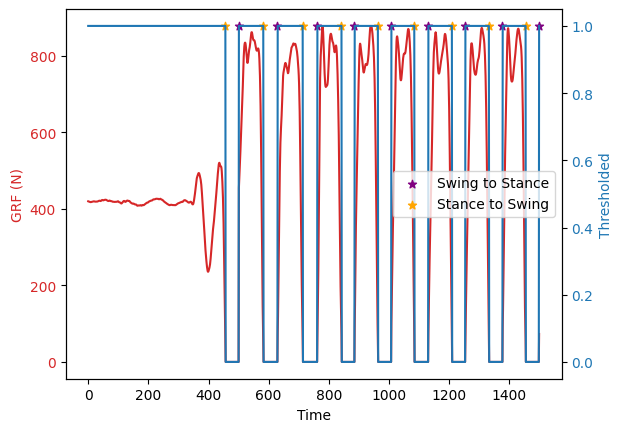

In [8]:
#Step 2: Find the start and end of the stance phase
# Use diff to find the stransitions from stance to swing
grf_thresh_diff = np.diff(grf_thresh.astype(int))

# Find the start and end of the stance phase
swing_to_stance = np.where(grf_thresh_diff == 1)[0]
stance_to_swing = np.where(grf_thresh_diff == -1)[0]

# Replicate the same plot, but with the stance to swing transitions and 
# stance to swing transitions as asterisk markers
start = 1500
end = start + 1500
grf_r_plot = grf_r[start:end]

# cutoff the transitions to be within the plot range
swing_to_stance_plot = swing_to_stance[(swing_to_stance > start) & (swing_to_stance < end)]
stance_to_swing_plot = stance_to_swing[(stance_to_swing > start) & (stance_to_swing < end)]

# Plot the first 150 points
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('GRF (N)', color=color)
ax1.plot(grf_r_plot, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Thresholded', color=color)
ax2.plot(grf_thresh_plot, color=color)
ax2.tick_params(axis='y', labelcolor=color)

y_scatter = np.ones_like(swing_to_stance_plot)

ax2.scatter(swing_to_stance_plot - start, y_scatter, color='purple', marker='*', label = 'Swing to Stance')
ax2.scatter(stance_to_swing_plot - start, y_scatter, color='orange', marker='*', label = 'Stance to Swing')
ax2.legend()



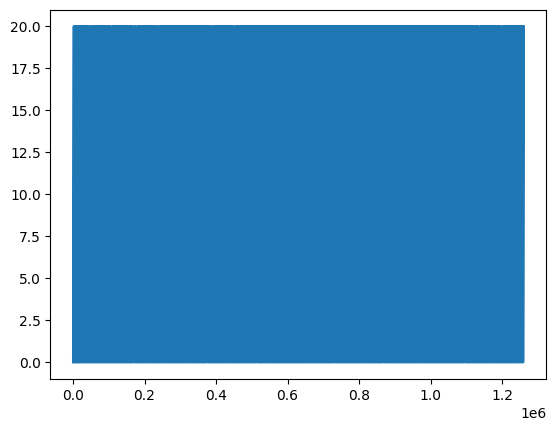

In [9]:
# Step 3: Calculate the stance phase duration

# Verify that time is reasonable
time = df['time_step'].values

# Plot the time for the dataset
plt.plot(time)


/home/jmontp/.conda/envs/jmontp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jmontp/.conda/envs/jmontp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Number of valid strides: 22295


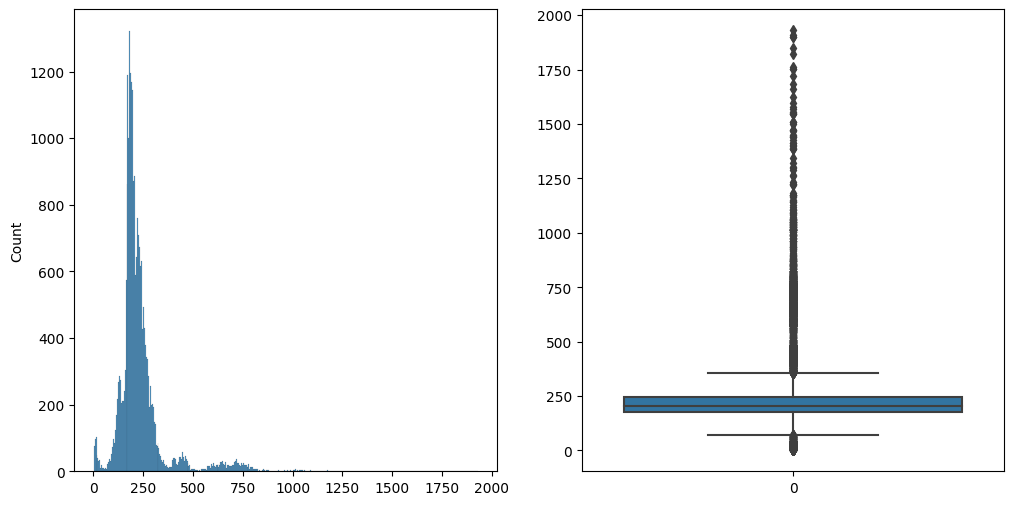

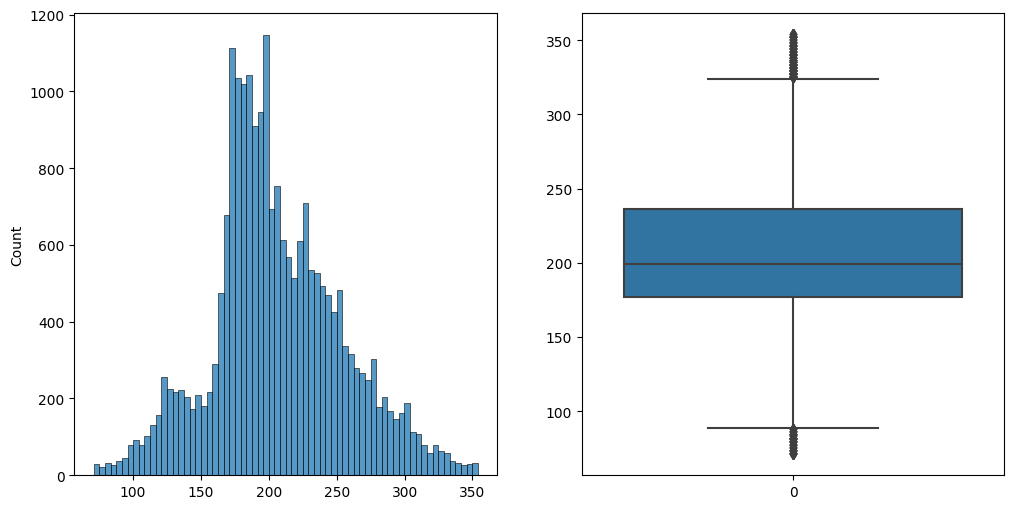

In [32]:
# Step 3 continued: Calculate the stance phase duration

# Calculate the stride time for each step. This is defined as the 
# time between consecutive swing to stance transitions. We want to create 
# a histogram of the stride time to identify the reasonable range of
# stride times. The unreasonable stride times will be removed from the
# dataset.

# Calculate the stride time
stride_time = time[swing_to_stance[1:]] - time[swing_to_stance[:-1]]

# Create a list that contains the indexes of the valid strides
valid_stride = np.arange(len(stride_time))

# First, remove the negative stride times
positive_strides = stride_time > 0
stride_time = stride_time[positive_strides]
valid_stride_num = valid_stride[positive_strides]

# Histogram of the stride time next to the box plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(stride_time, ax=ax[0])
sns.boxplot(stride_time, ax=ax[1])

# Remove all the outliers of the box plot
q1 = np.percentile(stride_time, 25)
q3 = np.percentile(stride_time, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Remove the outliers
in_bounds_strides = (stride_time > lower_bound) & (stride_time < upper_bound)
stride_time = stride_time[in_bounds_strides]
valid_stride_num = valid_stride_num[in_bounds_strides]

# Plot the histogram and box plot again
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(stride_time, ax=ax[0])
sns.boxplot(stride_time, ax=ax[1])

print(f"Number of valid strides: {len(stride_time)}")


In [38]:
# Step 4: Calculate the phase duration 
# Calculate the phase duration for each step. This is defined as a linear 
# interpolation between 0 and 1 from consecutive swing to stance transitions.
# We will also create a phase indexed data frame that will interpolate every 
# step to 150 data points.

# Create a list to store the phase for each data point
phase_list = []
valid_data_points = []

# Initialize the phase to -1. Every data point that is not part of a valid 
# stride will be -1
df['phase_r'] = -1.0

# Initialize the data frame to store the interpolated data
df_phase_all = pd.DataFrame()

# Calculate the stride phase for each step 
for i,valid_stride in enumerate(valid_stride_num):

    print(f"Percent complete: {i / len(valid_stride_num) * 100:.2f}%", end='\r')

    # Get the start and end of the stride
    start = swing_to_stance[valid_stride]
    end = swing_to_stance[valid_stride+1]
    
    # Calculate the phase
    phase = np.linspace(0, 1, end - start + 1)
    phase_list.extend(phase)

    # Calculate the valid points in the df
    stride_points = np.arange(start, end+1)
    valid_data_points.extend(stride_points)

    # Add the phase to the data frame
    df.loc[stride_points, 'phase_r'] = phase

    # Interpolate the data to 150 points
    phase_150_points = np.linspace(0, 1, 150)
    phase_stride_points = np.linspace(0, 1, end - start + 1)

    # Interpolate the data
    # Initialize a data frame to store the interpolated data
    df_interpolated = pd.DataFrame()
    for column in df.columns:
        if column in ['time_step', 'phase_r','subject', 'task']:
            continue
        data = df[column].values
        interpolated_data = np.interp(phase_150_points, phase_stride_points, 
                                      data[start:end+1])
        df_interpolated[column] = interpolated_data

    # Add the subject and task to the interpolated data
    df_interpolated['subject'] = df['subject'].iloc[start]
    df_interpolated['task'] = df['task'].iloc[start]

    # Add the interpolated data to the data frame
    if valid_stride == valid_stride_num[0]:
        df_phase_all = df_interpolated
    else:
        df_phase_all = pd.concat([df_phase_all, df_interpolated], 
                                        ignore_index=True)

# Filter the data frame to only include the valid data points
df_time_steady_state_only = df.iloc[valid_data_points,:]

# Add the phase to the filtered data frame
df_time_steady_state_only['phase'] = phase_list

# Print number of valid data points
print(f"Number of valid data points: {len(df_time_steady_state_only)}")
print(f"Average data points per stride: {len(df_time_steady_state_only) / len(stride_time)}")

/tmp/ipykernel_1771986/3114437864.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.         0.00378788 0.00757576 0.01136364 0.01515152 0.01893939
 0.02272727 0.02651515 0.03030303 0.03409091 0.03787879 0.04166667
 0.04545455 0.04924242 0.0530303  0.05681818 0.06060606 0.06439394
 0.06818182 0.0719697  0.07575758 0.07954545 0.08333333 0.08712121
 0.09090909 0.09469697 0.09848485 0.10227273 0.10606061 0.10984848
 0.11363636 0.11742424 0.12121212 0.125      0.12878788 0.13257576
 0.13636364 0.14015152 0.14393939 0.14772727 0.15151515 0.15530303
 0.15909091 0.16287879 0.16666667 0.17045455 0.17424242 0.1780303
 0.18181818 0.18560606 0.18939394 0.19318182 0.1969697  0.20075758
 0.20454545 0.20833333 0.21212121 0.21590909 0.21969697 0.22348485
 0.22727273 0.23106061 0.23484848 0.23863636 0.24242424 0.24621212
 0.25       0.25378788 0.25757576 0.26136364 0.26515152 0.26893939
 0.27272727 0.27651515 0.28

Number of valid data points: 5372281
Average data points per stride: 240.96348957165284


/tmp/ipykernel_1771986/3114437864.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['phase'] = phase_list


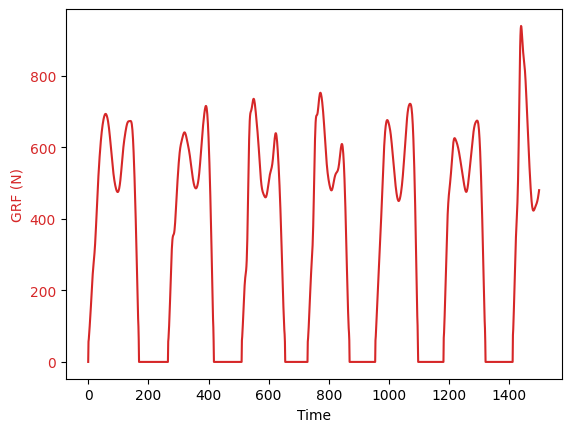

In [34]:
# Visualize the data

# Plot the first 1500 points of the GRF data
grf_new_data = df_time_steady_state_only['grf_y_r'].values

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('GRF (N)', color=color)
ax1.plot(grf_new_data[:1500], color=color)
ax1.tick_params(axis='y', labelcolor=color)


In [40]:
# Save the data to a new parquet file for the interpolated data
df_interpolated_all.to_parquet('Camargo2021_phase.parquet')

# Save the data to add the phase information
#df.to_parquet('Camargo2021_time.parquet')

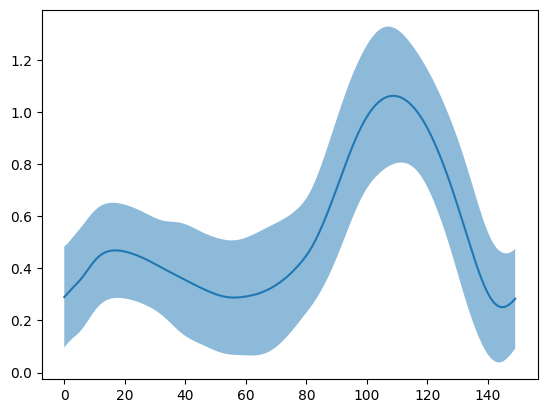

In [41]:
# Verify that the data is processed correctly for the phase dataset

# Plot the average knee angle over the gait phase
knee_angle = df_interpolated_all['knee_angle_s_r'].values

# Reshape the knee angle to be a 2D array
knee_angle_2d = knee_angle.reshape(-1, 150)

# Calculate the average and std deviation of the knee angle
average_knee_angle = np.mean(knee_angle_2d, axis=0)
std_knee_angle = np.std(knee_angle_2d, axis=0)

# Plot the average knee angle with the std deviation
plt.plot(average_knee_angle)
plt.fill_between(np.arange(150), average_knee_angle - std_knee_angle, 
                 average_knee_angle + std_knee_angle, alpha=0.5)
